# Session 02 - Classification

## Intro to Classification <table class="tfo-notebook-buttons" align="right" style="margin-top:-55px">
  <td>
      <a target="_blank" href="https://www.python.org/doc/"><img src="https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fwww.baptiste-donaux.fr%2Fpackager-application-python-avec-dependances%2Fpython.png&f=1&nofb=1"  width="60" height="50" /><p style='margin-left:8px'>PYTHON</p></a>
  </td>
 </table>

In [141]:
### LinearClassifier Example with perceptron training etc
###
from sklearn.datasets import make_classification
from sklearn.datasets import make_circles
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, roc_curve, auc
from matplotlib.colors import ListedColormap
import seaborn as sns
import warnings; warnings.filterwarnings('ignore')

## Data Load or Creation

In [142]:
X,y = make_classification(n_features=2,n_classes=2,n_samples=500,n_redundant=0,n_clusters_per_class=1)
# x,Y = make_circles(n_samples=100,noise=0.03,factor=0.7)


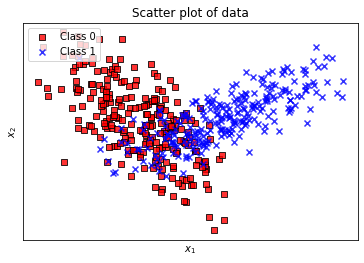

In [143]:
# Plot data
markers = ('s', 'x')
colors = ('red', 'blue')
target_names = ['Class 0', 'Class 1']
for idx, cl in enumerate(np.unique(y)):
    plt.scatter(x= X[y == cl, 0], y= X[y == cl, 1],
                alpha= 0.8, c= colors[idx],
                marker= markers[idx], label= target_names[cl], edgecolor= 'black') 
    
plt.xlabel('$x_1$'); plt.xticks([])
plt.ylabel('$x_2$'); plt.yticks([])
plt.title('Scatter plot of data')
plt.legend(loc="upper left")
plt.show()


## Data Split

In [144]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                     test_size= 0.25, 
                     stratify= y,
                     random_state= 123)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

X_train shape: (375, 2)
X_test shape: (125, 2)


## Standarization of data

In [145]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## General function for training and k fold validation

In [146]:
def plot_func(y_test,y_pred,title,y_prob,gs=None):
# ----------------------------------------------------- 
    fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(21, 7))
    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot = True, cbar = False, fmt = "d", linewidths = .5, cmap = "Blues", ax = ax1)
    ax1.set_title("Confusion Matrix")
    ax1.set_xlabel("Predicted class")
    ax1.set_ylabel("Actual class")
    fig.tight_layout()
    # -----------------------------------------------------
    # Plot ROC curve

        # fpr, tpr, _ = roc_curve(y_test)
   
    fpr, tpr, _ = roc_curve(y_test, y_prob)

    ax2.plot(fpr, tpr, lw = 2, label = 'AUC: {:.2f}'.format(auc(fpr, tpr)))
    ax2.plot([0, 1], [0, 1],
                linestyle = '--',
                color = (0.6, 0.6, 0.6),
                label = 'Random guessing')
    ax2.plot([0, 0, 1], [0, 1, 1],
                linestyle = ':',
                color = 'black', 
                label = 'Perfect performance')
    ax2.set_xlim([-0.05, 1.05])
    ax2.set_ylim([-0.05, 1.05])
    ax2.set_xlabel('False Positive Rate (FPR)')
    ax2.set_ylabel('True Positive Rate (TPR)')
    ax2.set_title('Receiver Operator Characteristic (ROC) Curve')
    ax2.legend(loc = "lower right")
    fig.tight_layout()  

    if(gs is not None):
        # -----------------------------------------------------
        # Plot the decision boundary
        cmap = ListedColormap(colors[:len(np.unique(y_test))])
        x1_min, x1_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
        x2_min, x2_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1
        resolution = 0.01 # step size in the mesh
        xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                            np.arange(x2_min, x2_max, resolution))
        Z = gs.best_estimator_.predict(np.c_[xx1.ravel(), xx2.ravel()])
        # Put the result into a color plot
        Z = Z.reshape(xx1.shape)
        plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
        # plot class samples
        for idx, cl in enumerate(np.unique(y_test)):
            plt.scatter(x= X_test[y_test == cl, 0], 
                        y= X_test[y_test == cl, 1],
                        alpha= 0.8, 
                        c= colors[idx],
                        marker= markers[idx], 
                        label= target_names[cl], 
                        edgecolor= 'black')    
        ax3.set_title('Decision boundary of '+ str(title))
        ax3.set_xlabel("$x_1$")
        ax3.set_ylabel("$x_2$")
        plt.xlim(xx1.min(), xx1.max())
        plt.ylim(xx2.min(), xx2.max())
        plt.xticks([]); plt.yticks([])
        plt.legend(loc='lower left')
        plt.show()   


### Simple preceptron model 💡

In [147]:
class LinearClassifier:
    def __init__(self):
        pass
    def sigmoid(self,z):
        return 1.0/(1. + np.exp(-z))

    def loss(self,y,y_ht):
        loss =  -np.mean( y*(np.log(y_ht)) - (1-y)*np.log(1-y_ht) )
        return loss

    def gradient(self,x,y,y_ht):
        m = x.shape[0]
        dw = (1/m)*np.dot(x.T,(y_ht-y)) #wrt w
        db = (1/m)*np.sum((y_ht-y)) # wrt bias
        return dw,db 

    def plot_dec_boundry(self,x,w,b,y,debug):
        x1 = [min(x[:,0]), max(x[:,0])]
        m = -w[0]/w[1]
        c = -b/w[1]
        x2 = m*x1 + c
        plt.plot(x[:,0][y==0], x[:,1][y==0],'r^')
        plt.plot(x[:,0][y==1], x[:,1][y==1],'bs')
        plt.plot(x1,x2,'y-')
        if debug:
            plt.show()

    def normalize(self,x):
        m,n = x.shape   #m : trg exmple, n: features
        for i in range(n):
            x = (x - x.mean(axis=0))/x.std(axis=0)
        return x    

    def fit(self, x,y,bs=10,epochs=9000,lr=0.01):
        m,n = x.shape
        w = np.zeros((n,1))  ## or random ?
        b = 0
        y = y.reshape(m,1)
        x = self.normalize(x)

        losses = []

        for epoch in range(epochs):
            for i in range((m-1)//bs+1):
                start_i = i*bs
                end_i = start_i + bs
                xb = x[start_i:end_i]
                yb = y[start_i:end_i]

                y_ht = self.sigmoid(np.dot(xb,w)+b)

                dw,db = self.gradient(xb,yb,y_ht)

                w -=lr*dw
                b -=lr*db

            l = self.loss(y,self.sigmoid(np.dot(x,w)+b))
            losses.append(l)
            # self.plot_dec_boundry(x,w,b,y,1)

        return w,b,losses

    def step_func(self,z):
        return 1.0 if (z > 0) else 0.0
    

    def predict(self,x,w,b):

        x = self.normalize(x)
        preds = self.sigmoid((np.dot(x,w)+b))
        pred_class = []

        pred_class = [1 if i>0.5 else 0 for i in preds]
        # print([np.array(pred_class),np.array(preds)])
        return np.array(pred_class),np.array(preds)
    
    def accuracy(self,y, y_ht):
        accuracy = np.sum(y == y_ht) / len(y)
        return accuracy



In [148]:
p = LinearClassifier()
w,b,loss = p.fit(X_train,y_train,bs=10,epochs=9000,lr=0.01)
print(w,b)
class_pred,_ = p.predict(X_train,w,b)
print('Train Accuracy= ',p.accuracy(y_train,class_pred) * 100,'%')


[[2.63958195]
 [0.51615545]] 0.2596540088616993
Train Accuracy=  82.66666666666667 %


Test Accuracy=  81.6 %


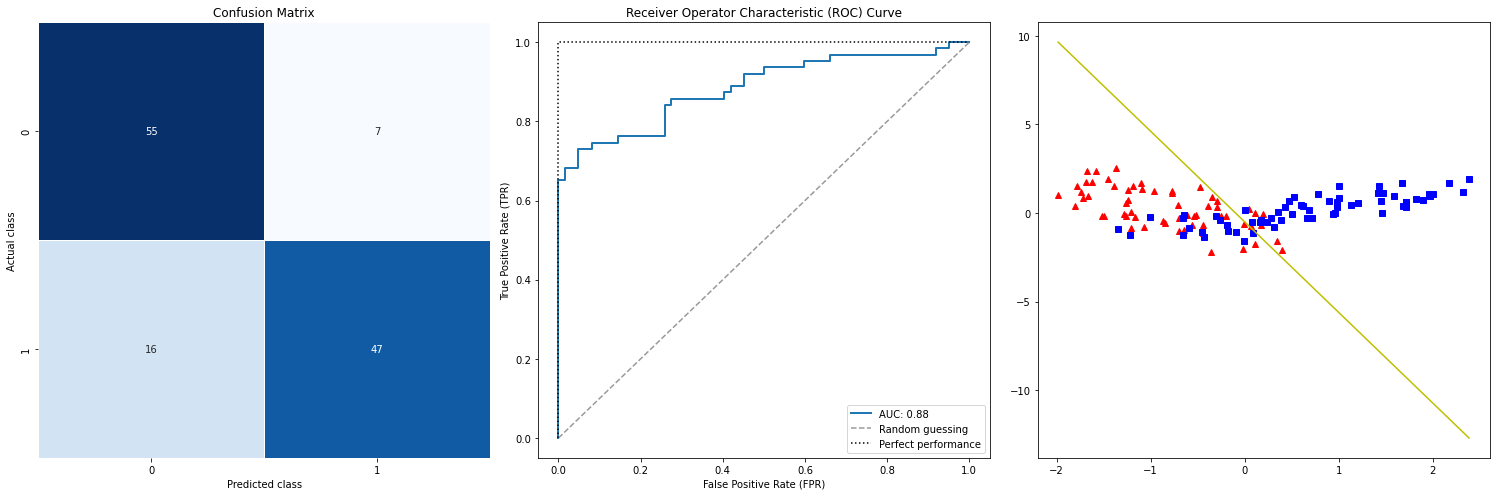

In [149]:
class_pred,class_prob = p.predict(X_test,w,b)
print('Test Accuracy= ',p.accuracy(y_test,class_pred) * 100,'%')

plot_func(y_test,class_pred,"Our Linear Prediction",y_prob=class_prob)
plt.subplot(1,3,3)
p.plot_dec_boundry(X_test,w,b,y_test,0)


## General function with k-fold validation

In [150]:
def run_classifier(clf, param_grid, title):
    # -----------------------------------------------------
    cv = StratifiedKFold(n_splits= 3, shuffle = True, random_state= 123)
    # Randomized grid search
    n_iter_search = 10
    gs = RandomizedSearchCV(clf, 
                            param_distributions = param_grid,
                            n_iter = n_iter_search, 
                            cv = cv, 
                            scoring= 'accuracy')
    # -----------------------------------------------------
    # Train model
    gs.fit(X_train, y_train)  
    print("The best parameters are %s" % (gs.best_params_)) 
    # Predict on test set
    y_pred = gs.best_estimator_.predict(X_test)
    # Get Probability estimates
    y_prob = gs.best_estimator_.predict_proba(X_test)[:, 1]
    # -----------------------------------------------------
    print('Accuracy score: %.2f%%' %(accuracy_score(y_test, y_pred)*100))  
    print('Precision score: %.2f%%' % (precision_score(y_test, y_pred)*100))
    print('Recall score: %.2f%%' % (recall_score(y_test, y_pred)*100))

    plot_func(y_test,y_pred,title,y_prob,gs)
    

## Library based Linear Classification

The best parameters are {'solver': 'newton-cg', 'penalty': 'l2'}
Accuracy score: 81.60%
Precision score: 87.04%
Recall score: 74.60%


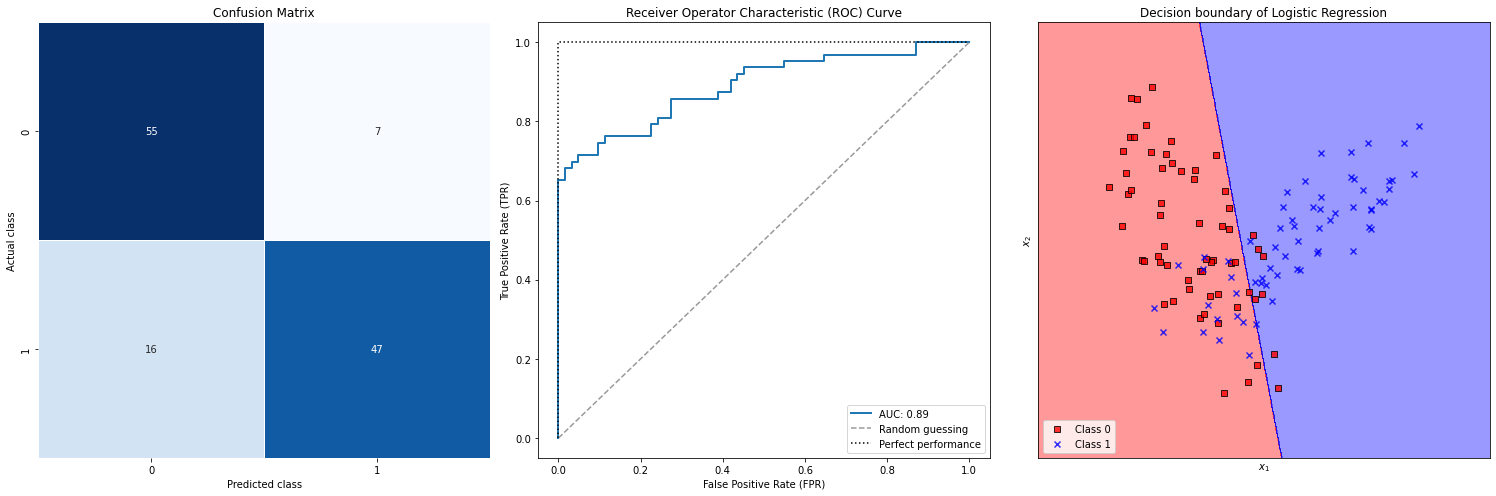

In [151]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

param_grid = {'penalty': ['l2'],
              'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

run_classifier(lr, param_grid, 'Logistic Regression')

## KNN Classification

The best parameters are {'weights': 'distance', 'n_neighbors': 14, 'leaf_size': 1, 'algorithm': 'auto'}
Accuracy score: 83.20%
Precision score: 87.50%
Recall score: 77.78%


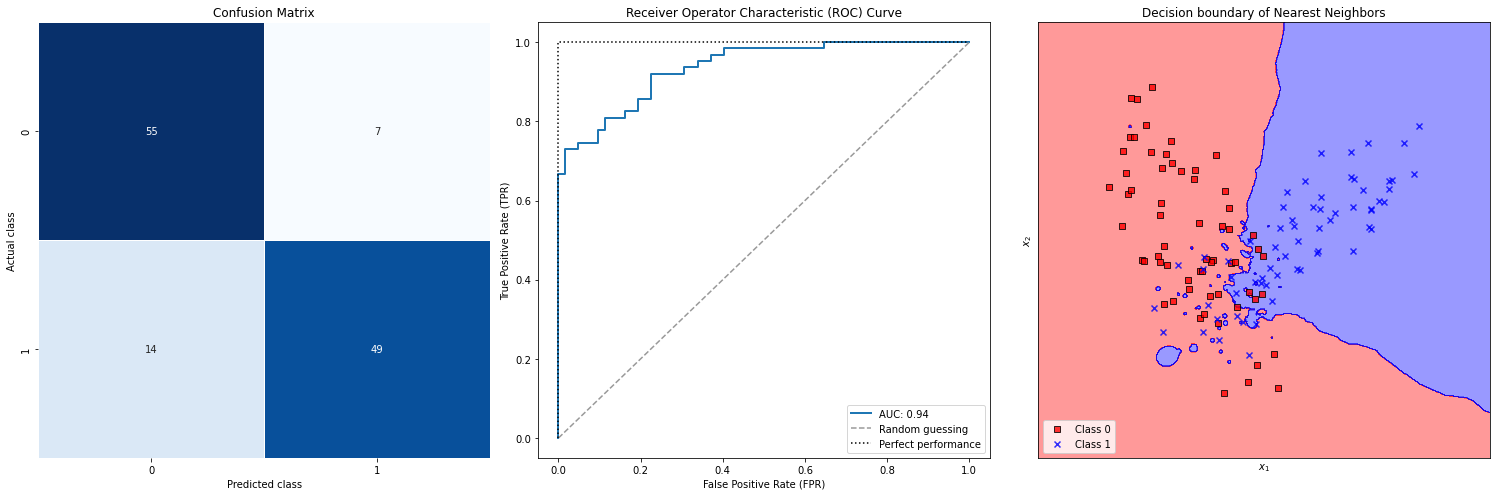

In [152]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

param_grid = {'n_neighbors': np.arange(1,15), 
             'weights': ['uniform', 'distance'],
             'leaf_size':[1, 3, 5],
             'algorithm':['auto', 'kd_tree']}

run_classifier(knn, param_grid, 'Nearest Neighbors')


## Naive Bayes Classification

The best parameters are {'priors': None}
Accuracy score: 83.20%
Precision score: 90.38%
Recall score: 74.60%


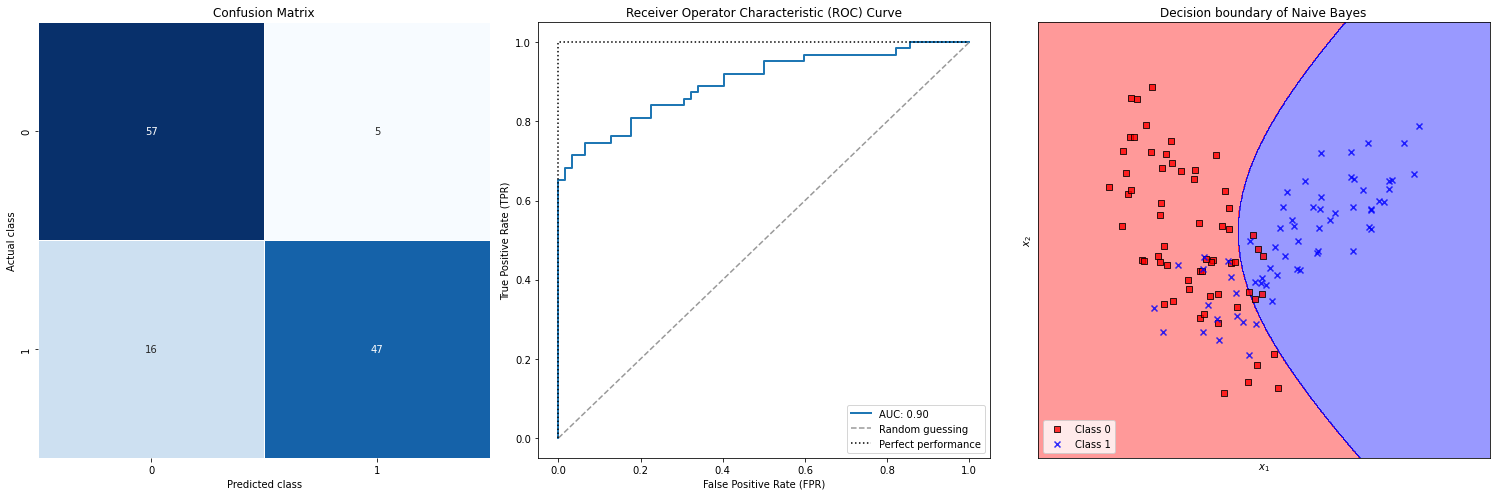

In [153]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()

param_grid = {'priors': [None]}

run_classifier(nb, param_grid, 'Naive Bayes')

## SVM Classification

The best parameters are {'gamma': 0.1, 'C': 1.0}
Accuracy score: 83.20%
Precision score: 92.00%
Recall score: 73.02%


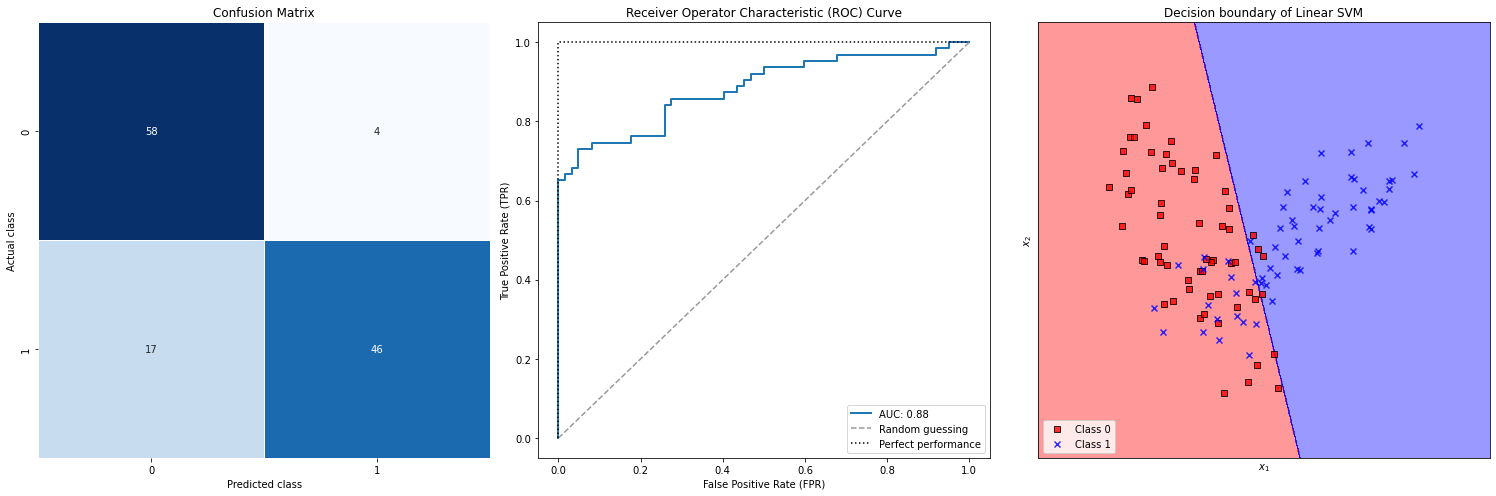

In [154]:
from sklearn.svm import SVC

svm_linear = SVC(kernel="linear", probability = True)

param_grid = {'gamma': np.logspace(-2, 2, 5),
              'C': np.logspace(-2, 2, 5)}

run_classifier(svm_linear, param_grid, 'Linear SVM')

## Radial Basis Function SVM Classification

The best parameters are {'gamma': 0.1, 'C': 10.0}
Accuracy score: 82.40%
Precision score: 88.68%
Recall score: 74.60%


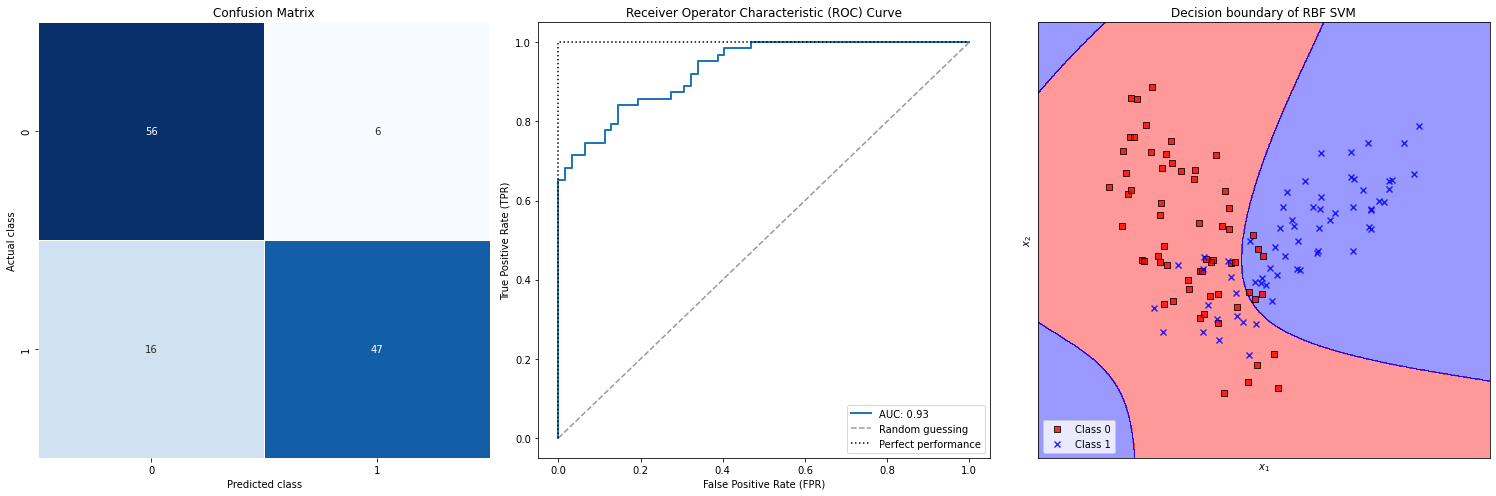

In [155]:
svm_rbf = SVC(kernel="rbf", probability=True)

param_grid = {'gamma': np.logspace(-2, 2, 5),
              'C': np.logspace(-2, 2, 5)}

run_classifier(svm_rbf, param_grid, "RBF SVM")

## Decision Tree Classification

The best parameters are {'splitter': 'random', 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 13, 'criterion': 'gini'}
Accuracy score: 80.80%
Precision score: 83.05%
Recall score: 77.78%


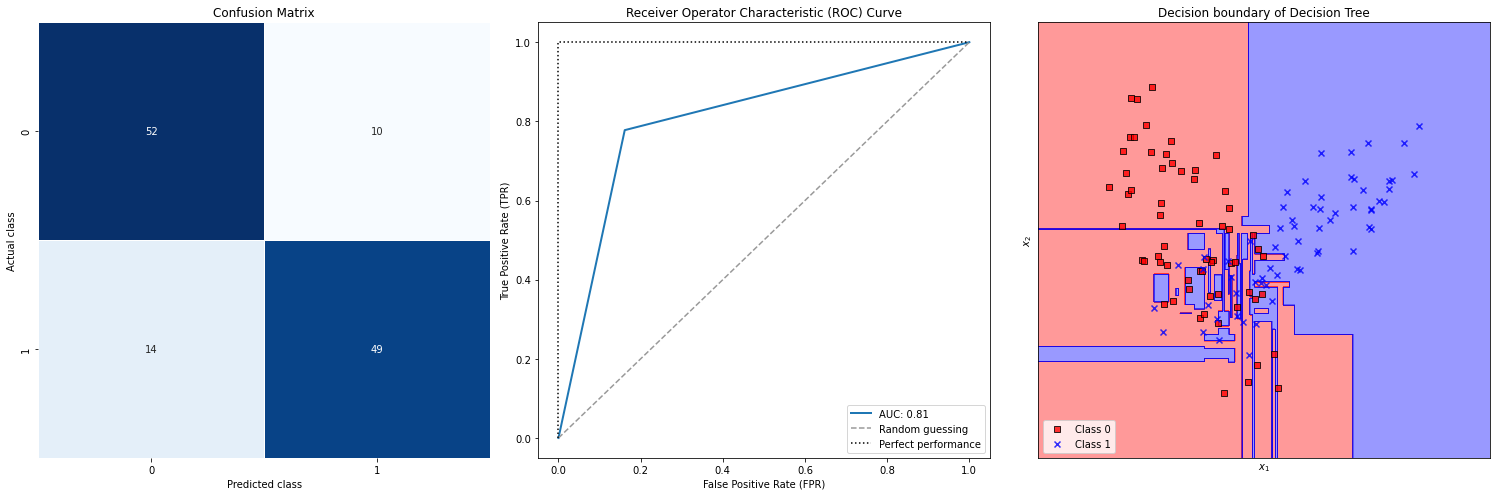

In [156]:
from sklearn.tree import DecisionTreeClassifier

dtree = DecisionTreeClassifier()

param_grid = {'criterion': ['gini', 'entropy'],
              'splitter': ['best', 'random'],
              'max_depth': np.arange(1, 20, 2),
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4, 10],
              'max_features': ['auto', 'sqrt', 'log2', None]}

run_classifier(dtree, param_grid, "Decision Tree")


## Random Forest Classification

The best parameters are {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 10, 'max_features': 'auto', 'max_depth': 100, 'criterion': 'entropy', 'bootstrap': False}
Accuracy score: 83.20%
Precision score: 88.89%
Recall score: 76.19%


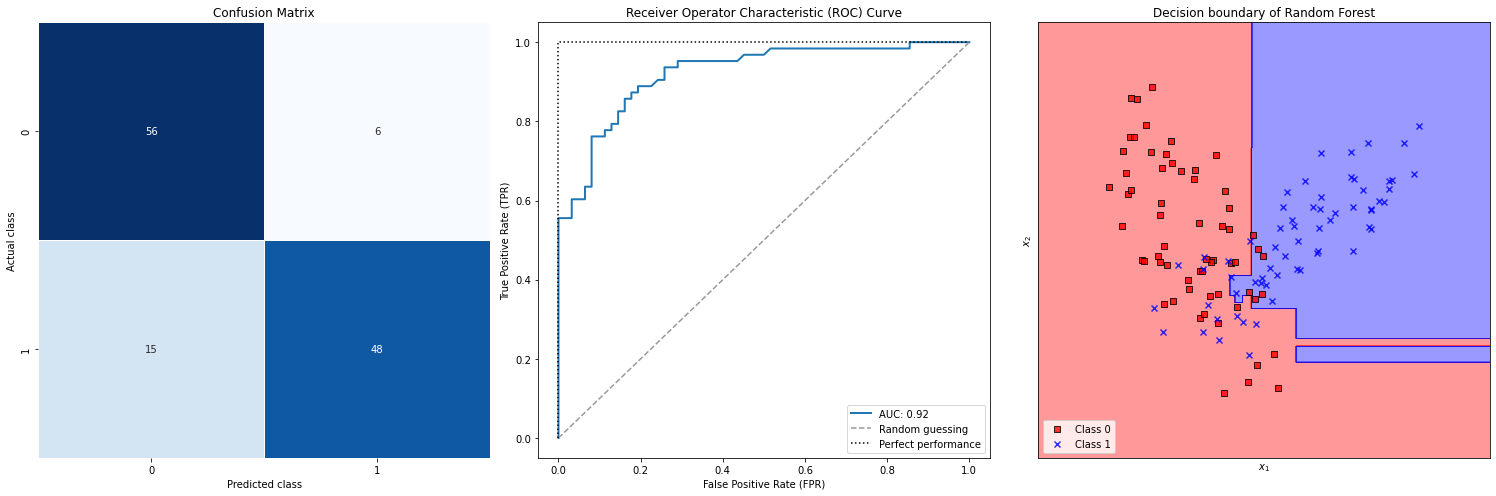

In [157]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

param_grid = {'n_estimators': [100, 200],
              'max_depth': [10, 20, 100, None],
              'max_features': ['auto', 'sqrt', None],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4, 10],
              'bootstrap': [True, False],
              'criterion': ['gini', 'entropy']}

run_classifier(rf, param_grid, 'Random Forest')

## Ensemble Classification

The best parameters are {'weights': [2, 1, 2]}
Accuracy score: 84.80%
Precision score: 89.29%
Recall score: 79.37%


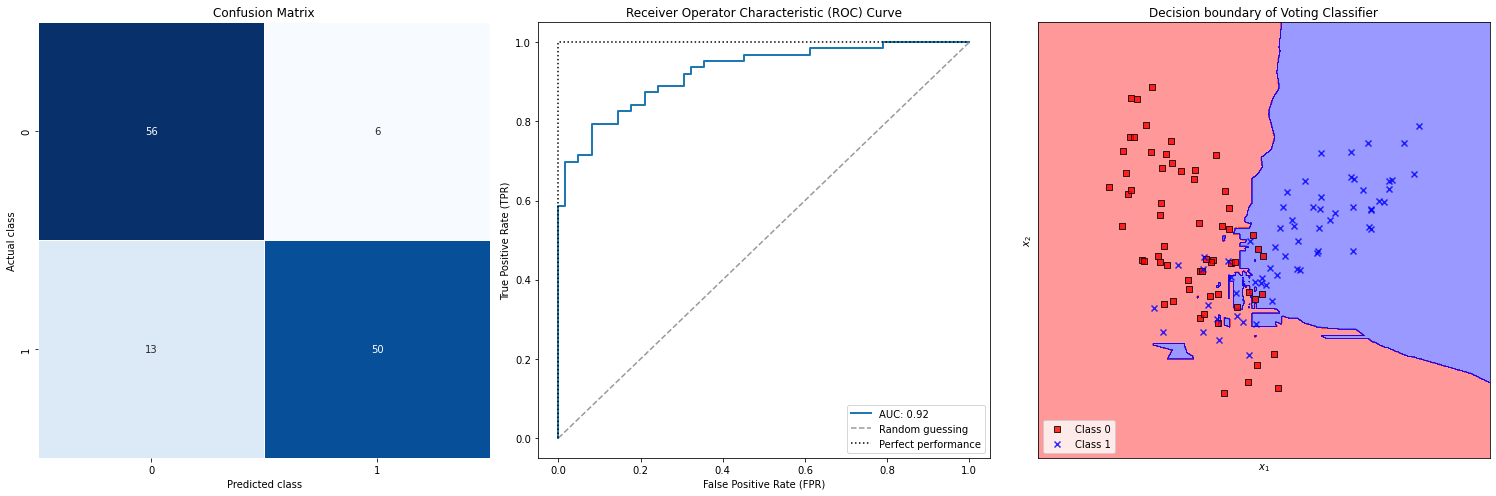

In [158]:
from sklearn.ensemble import VotingClassifier


vc = VotingClassifier(estimators=[('knn', knn), ('dt', dtree), ('svc', svm_rbf)],
                        voting='soft')

param_grid = {'weights': [[1, 1, 1], [2, 1, 2], [3, 1, 3]]}

run_classifier(vc, param_grid, "Voting Classifier")

## Neural Network Classification

The best parameters are {'solver': 'adam', 'max_iter': 100, 'learning_rate': 'constant', 'hidden_layer_sizes': (50, 50), 'alpha': 0.1, 'activation': 'identity'}
Accuracy score: 81.60%
Precision score: 87.04%
Recall score: 74.60%


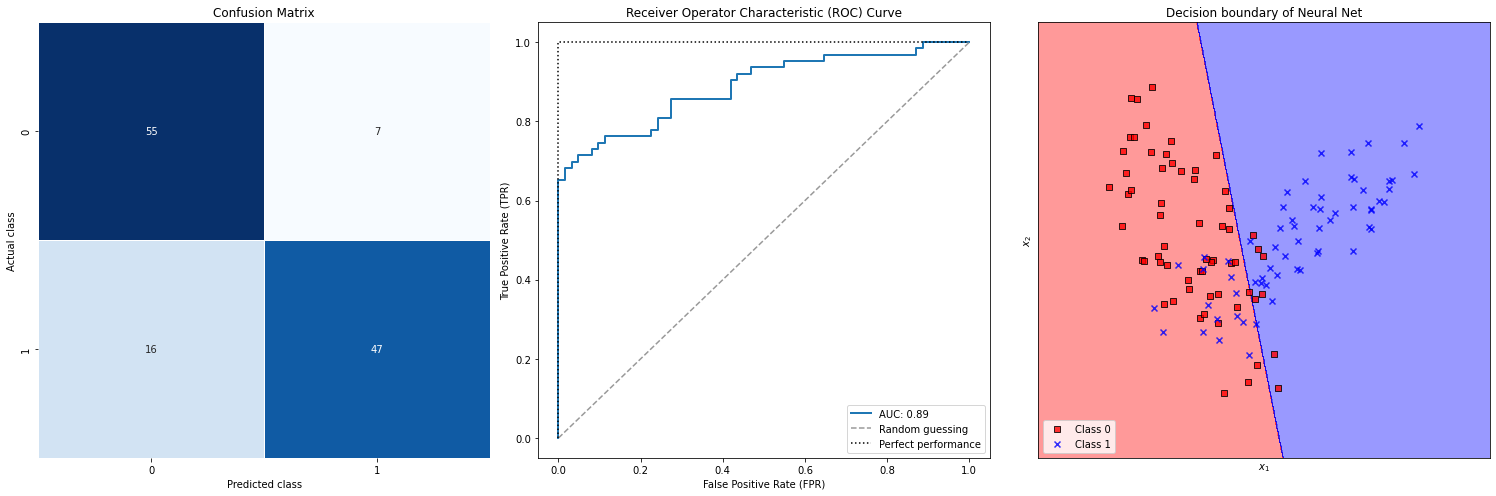

In [159]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier()

param_grid = {'hidden_layer_sizes': [(10,), (50,), (10, 10), (50, 50)],
             'activation': ['identity', 'logistic', 'tanh', 'relu'],
             'solver': ['lbfgs', 'sgd', 'adam'],
             'alpha': np.logspace(-5, 3, 5),
             'learning_rate': ['constant', 'invscaling','adaptive'],
             'max_iter': [100, 500, 1000]}

run_classifier(mlp, param_grid, 'Neural Net')

## Save and Close

In [160]:
%%javascript
IPython.notebook.save_checkpoint();
window.onbeforeunload = null
window.close();
IPython.notebook.session.delete();

<IPython.core.display.Javascript object>